# Scientific Computing 2: Numerical integration methods
This program implements and compares different numerical integration methods and estimates their convergence order.

In [2]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
def gaussian(u, o, x):
    return 1/(np.sqrt(2*np.pi)*o) * np.exp(-0.5*((x-u)/o)**2)

### Integration methods
The following integration methods are implemented:

1. **Composite trapezoidal rule**

    $\int_{a}^{b} f(x) \, dx \approx \frac{h}{2} \left[ f(x_0) + 2 \sum\limits_{i=1}^{N-1} f(x_i) + f(x_N) \right]$

2. **Composite Simpson's rule**

    $\int_{a}^{b} f(x) \, dx \approx \frac{h}{3} \left[ \frac{f(x_0)}{2} + \sum\limits_{i=1}^{N-1} f(x_i) + 2 \sum\limits_{i=1}^{N} f(\frac{x_{i-1} + x_i}{2}) + \frac{f(x_N)}{2} \right]$

3. **Composite midpoint rule**

    $\int_{a}^{b} f(x) \, dx \approx h \sum\limits_{i=1}^{N} f(x_i)$ &nbsp; where &nbsp; $x_i = a + \left( i − \frac{1}{2} \right) h$.

4. **Monte Carlo integration**

    $\int_{a}^{b} f(x) \, dx \approx \frac{{b - a}}{N} \sum\limits_{i=1}^{N} f(x_i)$

The methods are implemented using `numpy` functions and array slicing, resulting in much faster computation than with more naive approaches.

In [4]:
def comp_trap(x0, xN, N):
    # Initialize grid with N segments, x0 and xN are also used for segment length h:
    grid = np.linspace(x0, xN, num=N+1)

    # First and last position count half, sum rest of grid and add, multiply with h:
    return (xN-x0)/N * (f(grid[0])/2 + np.sum(f(grid[1:-1])) + f(grid[-1])/2)


def comp_simp(x0, xN, N):
    # Initialize grid with N segments, x0 and xN are also used for segment length h:
    grid = np.linspace(x0, xN, num=N+1)

    # Use array slicing for auxiliary grid with halfpoints:
    aux = (grid[1:] + grid[0:-1])/2

    # Apply Simpson's rule using the two grids:
    return (xN-x0)/(3*N) * (f(grid[0])/2 + np.sum(f(grid[1:-1])) + 2*np.sum(f(aux)) + f(grid[-1])/2)


def comp_midp(x0, xN, N):
    # Initialize grid with N segments, x0 and xN are also used for segment length h:
    grid = np.linspace(x0, xN, num=N+1)

    # Use h to find midpoints and get function value from there:
    return (xN-x0)/N * np.sum(f(grid[1:] - (xN-x0)/(2*N)))


def mont_carl(x0, xN, N):
    # Initialize grid with size N and uniformly random numbers between x0 and xN:
    grid = np.random.uniform(x0, xN, size=N+1)
    
    # Sum all function values at random positions and divide interval by number of positions:
    return (xN-x0)/N * np.sum(f(grid))

### Integration methods test
This test highlights the speed of the methods implemented, allowing computation with very high precision (high number of segments) in a reasonable amount of time.

In [5]:
mu = 3
sigma = 2

f = lambda x : gaussian(mu, sigma, x)

domain_start = 0
domain_stop = 5

trap = lambda n : comp_trap(domain_start, domain_stop, n)
simp = lambda n : comp_simp(domain_start, domain_stop, n)
midp = lambda n : comp_midp(domain_start, domain_stop, n)
carl = lambda n : mont_carl(domain_start, domain_stop, n)

# Test with 100 million segments:
n_segments = 10**8

tick = time.time()
print(trap(n_segments), "Trapezoidal")
print(simp(n_segments), "Simpson")
print(midp(n_segments), "Midpoint")
print(carl(n_segments), "Monte Carlo")
tock = time.time()

# Calculate and print the execution time:
speed = tock - tick
print(f"{speed:.2f} seconds")

0.7745375447996814 Trapezoidal
0.7745375447996853 Simpson
0.7745375447996872 Midpoint
0.7745198546405138 Monte Carlo
3.98 seconds


### Convergence plot error calculation
The convergence plot shows the *h*-convergence order of the different methods by getting an "exact" (= very accurate) solution that takes longer to compute and comparing it to the different methods and then calculating the relative error $\left|\frac{{P_N - P}}{{P}}\right|$ of the different methods compared to that.

In [6]:
# Get "exact" integral of the distribution using a SciPy function or high N trapezoidal:
gaus_sc = sp.integrate.quad(f, domain_start, domain_stop)[0]
gaus_cp = trap(10**9)

In [7]:
# Create array of evenly spaced values on a log scale:
scale = np.logspace(start=0, stop=4, base=10, num=57, dtype=int)

# Vectorize functions to apply to an array:
v_trap = np.vectorize(trap)
v_simp = np.vectorize(simp)
v_midp = np.vectorize(midp)
v_carl = np.vectorize(carl)

gaus = gaus_cp

# Calculate errors relative to "exact" integral:
error_trap = abs((v_trap(scale)-gaus)/gaus)
error_simp = abs((v_simp(scale)-gaus)/gaus)
error_midp = abs((v_midp(scale)-gaus)/gaus)
error_carl = abs((v_carl(scale)-gaus)/gaus)

### Final convergence plot
In addition to the integration method convergence, also some reference convergence orders are plotted in gray.

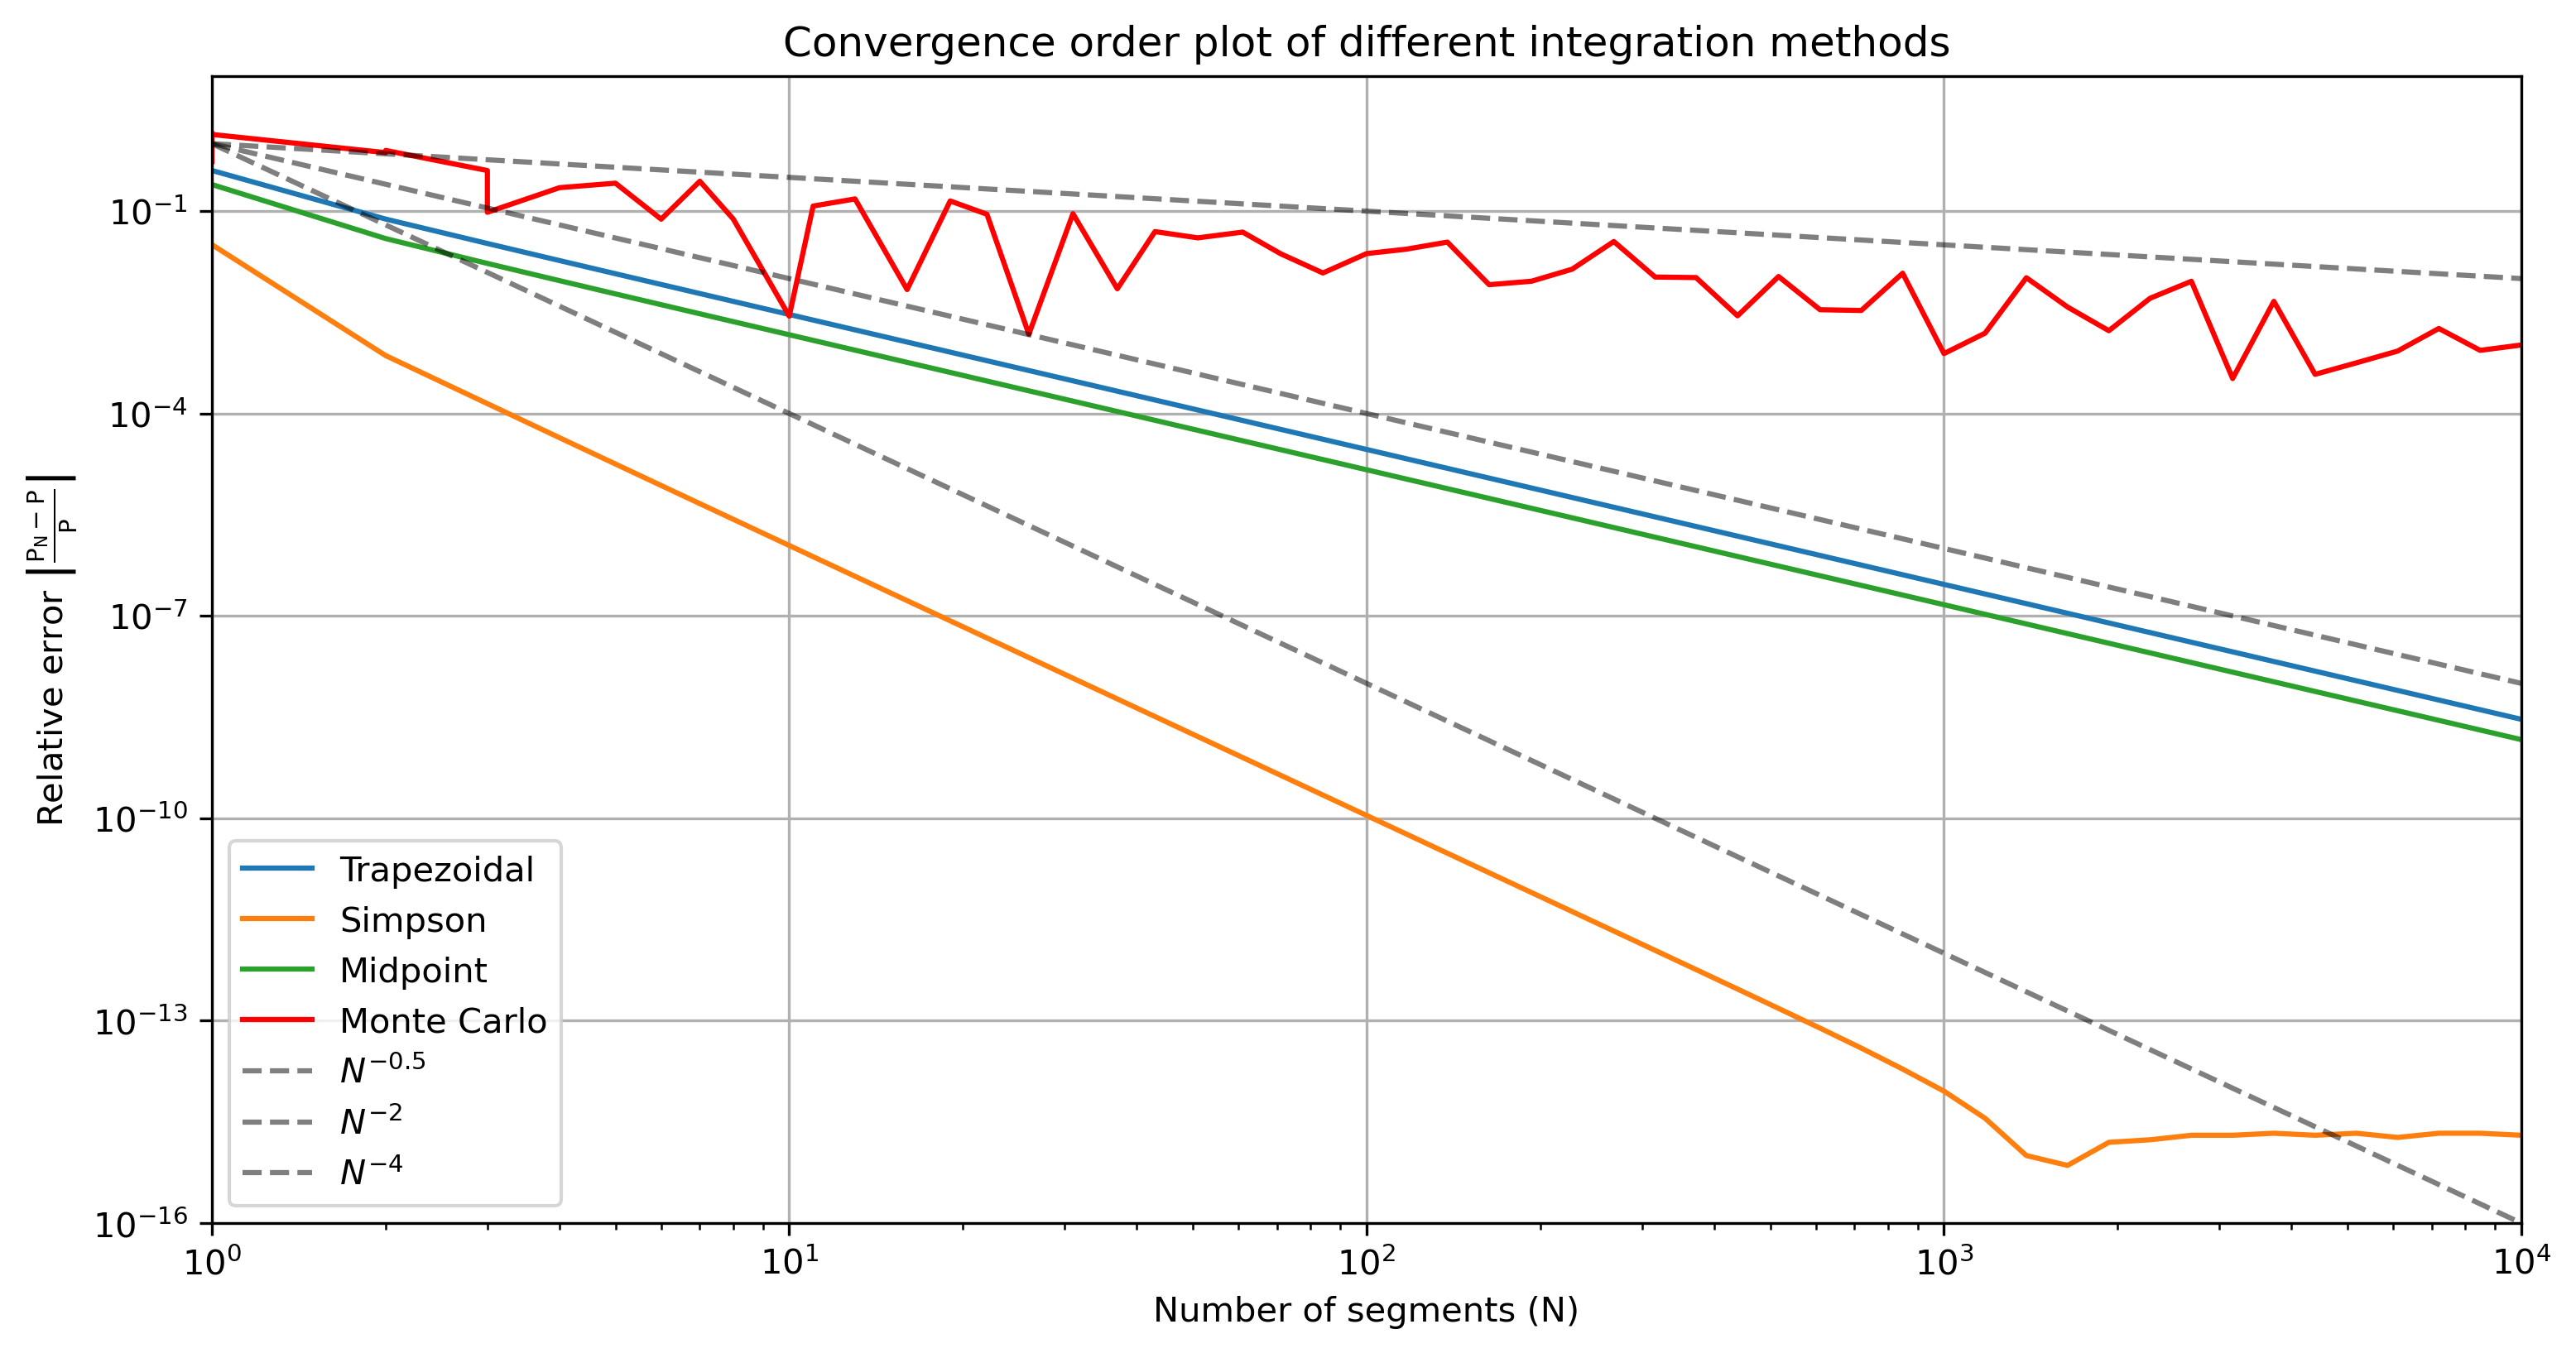

In [14]:
plt.figure(figsize=(12, 6), dpi=300)
plt.loglog(scale, error_trap, label="Trapezoidal")
plt.loglog(scale, error_simp, label="Simpson")
plt.loglog(scale, error_midp, label="Midpoint")
plt.loglog(scale, error_carl, color="red", label="Monte Carlo")

plt.loglog(scale, 1/scale**(1/2), linestyle="dashed", color="black", alpha=0.5, label=r"${N^{-0.5}}$")
plt.loglog(scale, 1/scale**(2), linestyle="dashed", color="black", alpha=0.5, label=r"${N^{-2}}$")
plt.loglog(scale, 1/scale**(4), linestyle="dashed", color="black", alpha=0.5, label=r"${N^{-4}}$")

plt.title("Convergence order plot of different integration methods")
plt.xlim(10**0, 10**4)
plt.ylim(10**-16, 10**1)
plt.xlabel("Number of segments (N)")
plt.ylabel(r"Relative error $\mathrm{\left|\frac{{P_N - P}}{{P}}\right|}$")
plt.legend()
plt.grid()
plt.show()

### Convergence order
The convergence order is also calculated using a linear model and then printed.

In [9]:
# Rescale x coordinates for linear model and reshape for sklearn function:
x = np.array(np.log(scale[0:40]).reshape((-1, 1)))

# Rescale y coordinates for linear model:
y_trap = np.log(error_trap[0:40])
y_simp = np.log(error_simp[0:40])
y_midp = np.log(error_midp[0:40])
y_carl = np.log(error_carl[0:40])

# Linear models:
lm_trap = LinearRegression().fit(x, y_trap)
lm_simp = LinearRegression().fit(x, y_simp)
lm_midp = LinearRegression().fit(x, y_midp)
lm_carl = LinearRegression().fit(x, y_carl)

# Resulting h-convergence orders:
print("Approximate convergence order:")
print(lm_trap.coef_, "Trapezoidal")
print(lm_simp.coef_, "Simpson")
print(lm_midp.coef_, "Midpoint")
print(lm_carl.coef_, "Monte Carlo")

Approximate convergence order:
[-2.03285085] Trapezoidal
[-4.10938419] Simpson
[-2.05554756] Midpoint
[-0.77272136] Monte Carlo
